# Analysis of the sodium simulations

This notebook contains the analysis of the results of the reference simulations and the multithermal-multibaric simulation. This includes the comparison of the free energies and calculation of the phase diagram. Here you will find the input to create most of the figures of the paper.

This notebook is organized as follows:
- References
    - Example - 350 K and 1 bar
    - All results
- Multithermal multibaric simulation
    - Free energies
    - Phase diagram
    - Order parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###################################################################
# Plot options
###################################################################

font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (15,7)

###################################################################
# Colors
###################################################################
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
MarkerSize=20
palette=tableau20

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    rgb=tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return tuple([x/255. for x in rgb])

from matplotlib.colors import LinearSegmentedColormap

my_colormap=LinearSegmentedColormap.from_list("my_colormap", [palette[0],hex_to_rgb("#ffffff"), palette[2] ], N=1000)

## References

### Example - 350 K and 1 bar

In [3]:
reference250K1bar=np.genfromtxt("02_References/Example/COLVAR")

CV vs time

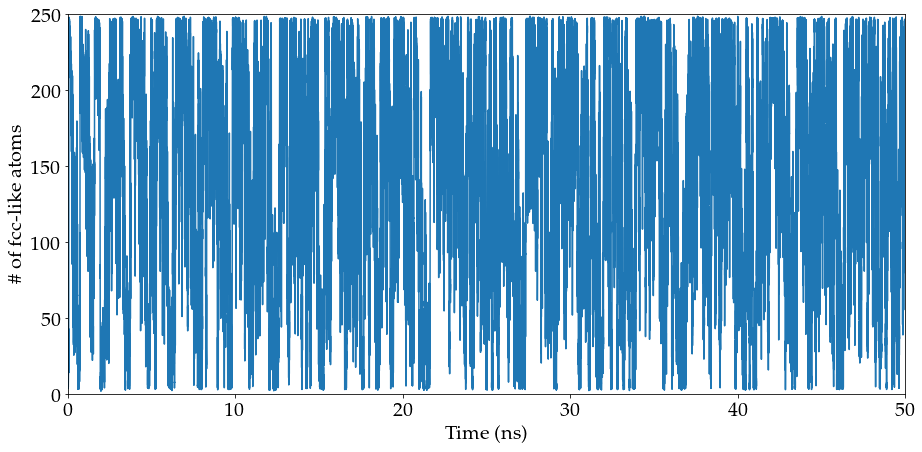

In [4]:
cv=reference250K1bar[:,4]
time=reference250K1bar[:,0]/1000 #ns

plt.plot(time,cv)
plt.xlabel("Time (ns)")
plt.ylabel("\# of fcc-like atoms")

plt.xlim([0,50])
plt.ylim([0,250])
plt.show()

Coefficients as a function of time

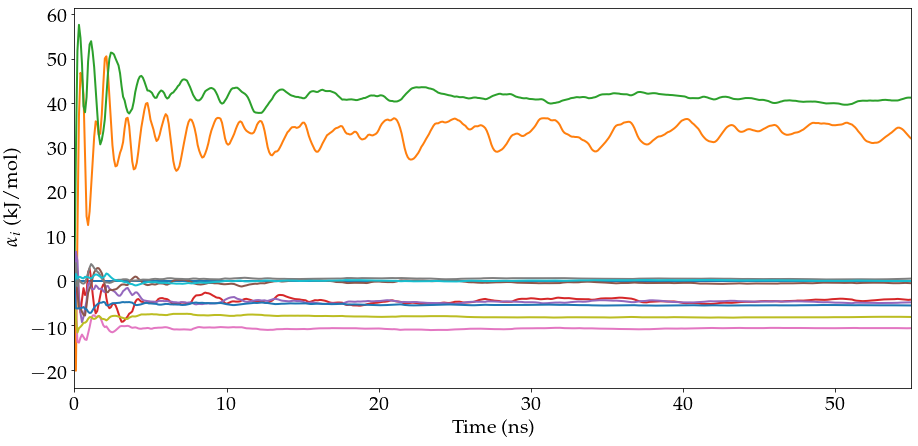

In [5]:
coeffs=np.genfromtxt("02_References/Example/coeffs.data")
numCoeffs=11
numEntries=int(coeffs.shape[0]/numCoeffs)
time=np.linspace(0,55,numEntries)
plt.plot(time,coeffs[:,1].reshape(numEntries,numCoeffs),linewidth=2.0)

plt.xlabel("Time (ns)")
plt.ylabel(r"$\alpha_i$ (kJ/mol)")

plt.xlim([0,55])

plt.show()

Final estimation of the free energy surface

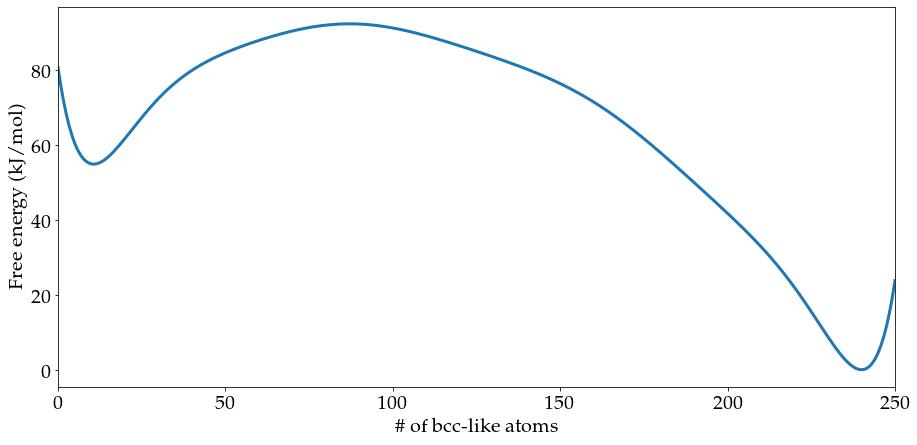

In [6]:
fes=np.genfromtxt("02_References/Example/fes.b1.iter-55000.data")

plt.plot(fes[:,0],fes[:,1],linewidth=3)

plt.xlim([0,250])

plt.xlabel("\# of bcc-like atoms")
plt.ylabel("Free energy (kJ/mol)")

plt.show()

### All results

In [7]:
references0bar=np.genfromtxt("02_References/Pressure1bar/results.txt")
references10000bar=np.genfromtxt("02_References/Pressure10000bar/results.txt")

Results at 1 bar

In [8]:
from tabulate import tabulate
table = np.reshape(references0bar, (3, 6), 'F')
print(tabulate(table, headers=["Temp (K)","Free energy (kJ/mol)","Std","StdOfMean","Min","Max"],tablefmt='github'))

|   Temp (K) |   Free energy (kJ/mol) |     Std |   StdOfMean |      Min |      Max |
|------------|------------------------|---------|-------------|----------|----------|
|        350 |                58.1503 | 1.44618 |    0.482061 |  60.9614 |  56.4296 |
|        375 |                12.4433 | 1.62649 |    0.542164 |  15.6466 |  10.5932 |
|        400 |               -33.4886 | 1.30919 |    0.436395 | -31.5176 | -35.5395 |


Results at 10000 bar

In [9]:
from tabulate import tabulate
table = np.reshape(references10000bar, (3, 6), 'F')
print(tabulate(table, headers=["Temp (K)","Free energy (kJ/mol)","Std","StdOfMean","Min","Max"],tablefmt='github'))

|   Temp (K) |   Free energy (kJ/mol) |     Std |   StdOfMean |      Min |      Max |
|------------|------------------------|---------|-------------|----------|----------|
|        400 |                61.8438 | 1.50973 |    0.533771 |  64.7784 |  58.9741 |
|        425 |                23.0837 | 1.49833 |    0.529738 |  25.4015 |  20.4024 |
|        450 |               -15.5799 | 2.10891 |    0.745612 | -12.1457 | -18.4404 |


## Multithermal-multibaric simulation

In [10]:
COLVAR=np.genfromtxt("03_MultithermalMultibaric/Reweight/COLVARtrim")

In [11]:
CV=COLVAR[:,4]
vesBias=COLVAR[:,5]
energy=COLVAR[:,1]
energy2=np.copy(COLVAR[:,1])
energy-=np.mean(energy)
vol=COLVAR[:,2]
vol2=np.copy(COLVAR[:,2])
vol-=np.mean(vol)
wallBias=COLVAR[:,9]
totalBias=vesBias+wallBias
temp=400
beta=1./(0.00831441001626*temp)
pressure=5000*0.06022140857

Compute mean and errors with batches

In [12]:
def batch(data,total_batch_num,batch_num):
    if (batch_num<0):
        raise Exception('batch_num must be greater than 0! Start from index 0')
    if (batch_num>(total_batch_num-1)):
        raise Exception('batch_num must be smaller than total_batch_num-1!')
    batch_size=int(data.shape[0]/total_batch_num)
    start=batch_size*batch_num
    end=batch_size*(batch_num+1)
    if (end>data.shape[0]):
        end=data.shape[0]
    return data[start:end]

In [13]:
def freeEnergies(CV,bias,vol,temperature,pressure,tempPrimes,pressurePrimes,total_batch_num,CVlimit):
    N=tempPrimes.shape[0]
    M=pressurePrimes.shape[0]
    freeEnergiesStruct=np.zeros([N,M,total_batch_num])
    beta=1./(0.00831441001626*temperature)
    for i in range(N):
        betaPrime=1./(0.00831441001626*tempPrimes[i])
        for j in range(M):
            for k in range(total_batch_num):
                probLiquid=np.sum(np.exp(beta*batch(bias[CV<=CVlimit],total_batch_num,k))*np.exp((beta-betaPrime)*batch(energy[CV<=CVlimit],total_batch_num,k)+(beta*pressure-betaPrime*pressurePrimes[j])*batch(vol[CV<=CVlimit],total_batch_num,k)))
                probSolid=np.sum(np.exp(beta*batch(bias[CV>=CVlimit],total_batch_num,k))*np.exp((beta-betaPrime)*batch(energy[CV>=CVlimit],total_batch_num,k)+(beta*pressure-betaPrime*pressurePrimes[j])*batch(vol[CV>=CVlimit],total_batch_num,k)))
                freeEnergiesStruct[i,j,k]=-(1./betaPrime)*np.log(probSolid/probLiquid)
    return freeEnergiesStruct

Comparison between energy, volume and CV fluctuation in the isothermal-isobaric and multithermal-multibaric ensemble

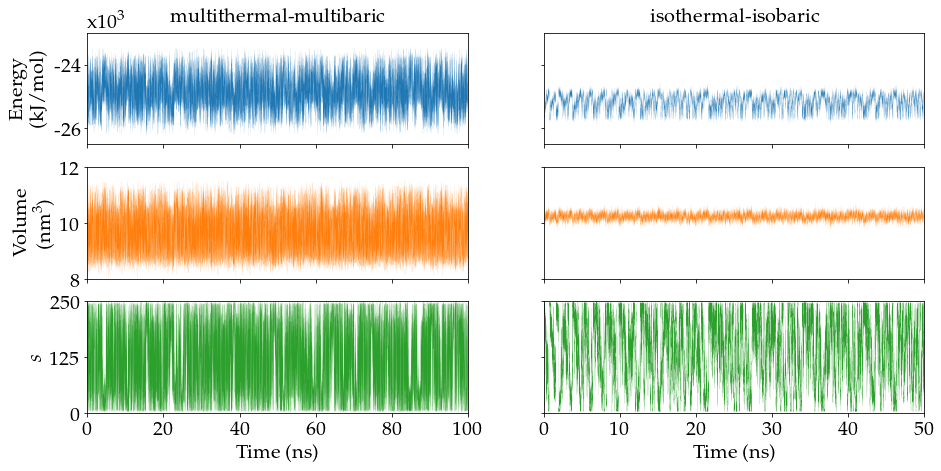

In [14]:
fig = plt.figure() 

ax1 = plt.subplot2grid((3,2), (0,0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3,2), (1,0), colspan=1, rowspan=1) #, projection='3d')
ax3 = plt.subplot2grid((3,2), (2,0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3,2), (0,1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3,2), (1,1), colspan=1, rowspan=1) #, projection='3d')
ax6 = plt.subplot2grid((3,2), (2,1), colspan=1, rowspan=1)
indeces=np.r_[0:14000,30000:94000,120000:CV.shape[0]]
#print(indeces)

x=np.linspace(0,energy2.shape[0]/1000,energy2.shape[0])

ax1.plot(x,energy2,linewidth=0.05,color=palette[0])
ax2.plot(x,vol2,linewidth=0.05,color=palette[2])
ax3.plot(x,CV,linewidth=0.05,color=palette[4])

ax1.set_xticks(np.arange(0,120,20))
ax2.set_xticks(np.arange(0,120,20))
ax3.set_xticks(np.arange(0,120,20))

ax1.set_xlim([0,100])
ax2.set_xlim([0,100])
ax3.set_xlim([0,100])
ax4.set_xlim([0,50])
ax5.set_xlim([0,50])
ax6.set_xlim([0,50])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])

ax3.set_xlabel("Time (ns)")
ax6.set_xlabel("Time (ns)")

ref = np.genfromtxt("02_References/Example/COLVAR")    
                    
ax4.plot(ref[:,0]/1000,ref[:,1],color=palette[0],alpha=1.0,linewidth=0.05)
ax5.plot(ref[:,0]/1000,ref[:,2],color=palette[2],alpha=1.0,linewidth=0.05)
ax6.plot(ref[:,0]/1000,ref[:,4],color=palette[4],alpha=1.0,linewidth=0.1)


ax1.set_ylim([-26500,-23000])
ax4.set_ylim([-26500,-23000])
ax2.set_ylim([8,12])
ax5.set_ylim([8,12])
ax3.set_ylim([0,250])
ax6.set_ylim([0,250])

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax1.set_yticklabels(["-26","-26","-24"])
ax1.text(0,-22700,r"x$10^3$",ha='left',va='center')


ax3.set_yticks([0,125,250])
ax6.set_yticks([0,125,250])

ax1.set_ylabel("Energy \n(kJ/mol)")
ax2.set_ylabel("Volume \n"+ r" (nm$^3$)")
ax3.set_ylabel(r"$s$")

ax1.text(50,-22500,r"multithermal-multibaric",ha='center',va='center')

ax4.text(25,-22500,"isothermal-isobaric",ha='center',va='center')

#plt.savefig("/home/piaggp/Desktop/plot-SI-al-fcc-traj.pdf", bbox_inches='tight')
#plt.savefig("/home/piaggp/Desktop/plot-SI-na-traj.png", bbox_inches='tight',dpi=300)

plt.show()

/home/local/PRINCETON/ppiaggi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


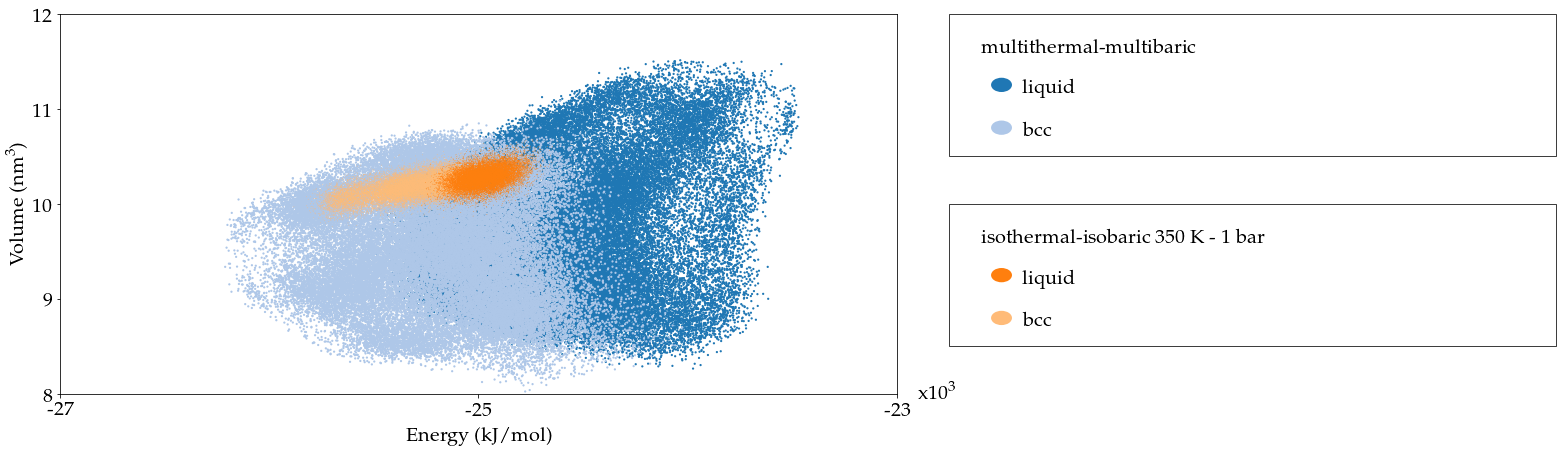

In [15]:
fig = plt.figure()

x=energy2
y=vol2
cv=CV
plt.scatter(x[cv<125],y[cv<125],s=5.0,color=palette[0],alpha=1.0,edgecolors='none')
plt.scatter(x[cv>125],y[cv>125],s=5.0,color=palette[1],alpha=1.0,edgecolors='none')

x=ref[10000:,1]
y=ref[10000:,2]
cv=ref[10000:,4]
plt.scatter(x[cv>125],y[cv>125],s=0.5,color=palette[3],alpha=1.0,edgecolors='none')
plt.scatter(x[cv<125],y[cv<125],s=0.5,color=palette[2],alpha=1.0,edgecolors='none')

plt.yticks(np.arange(8,13,1))
plt.xticks([-27000,-25000,-23000],["-27","-25","-23"])
plt.text(-22900,8,r"x$10^3$",ha='left',va='center')

plt.xlim([-27000,-23000])
plt.ylim([8,12])

plt.xlabel("Energy (kJ/mol)")
plt.ylabel(r"Volume (nm$^3$)")


ax = plt.subplot(111)
ax.add_patch(plt.Rectangle((-22750,8.5),2900, 1.5,facecolor='white',edgecolor='black',
                              clip_on=False,linewidth = 0.75))
ax.add_patch(plt.Rectangle((-22750,10.5),2900, 1.5,facecolor='white',edgecolor='black',
                              clip_on=False,linewidth = 0.75))

from matplotlib.patches import Ellipse

ax.add_patch(Ellipse((-22500,11.25),100,0.15,facecolor=palette[0],
                              clip_on=False,linewidth = 0.))
ax.add_patch(Ellipse((-22500,10.8),100,0.15,facecolor=palette[1],
                              clip_on=False,linewidth = 0.))

ax.add_patch(Ellipse((-22500,9.25),100,0.15,facecolor=palette[2],
                              clip_on=False,linewidth = 0.))
ax.add_patch(Ellipse((-22500,8.8),100,0.15,facecolor=palette[3],
                              clip_on=False,linewidth = 0.))

ax.text(-22600,11.6,"multithermal-multibaric")
ax.text(-22600,9.6,"isothermal-isobaric 350 K - 1 bar")

ax.text(-22400,11.175,"liquid")
ax.text(-22400,10.725,"bcc")

ax.text(-22400,9.175,"liquid")
ax.text(-22400,8.725,"bcc")

#plt.savefig("/home/piaggp/Desktop/plot-SI-al-fcc-EV.pdf", bbox_inches='tight')
#plt.savefig("/home/piaggp/Desktop/plot-SI-na-EV.png", bbox_inches='tight',dpi=300)

plt.show()

### Free energies

In [16]:
N=41
M=41
tempPrimes=np.linspace(350,450,N)
pressurePrimes=0.06022140857*np.linspace(0,10000,M)
temperature=400
pressure=5000*0.06022140857
total_batch_num=20

# This calculation takes time and it is often convenient to save the results
#freeEnergiesBcc=freeEnergies(CV,totalBias,vol,temperature,pressure,tempPrimes,pressurePrimes,total_batch_num,125)
freeEnergiesBcc=np.load("03_MultithermalMultibaric/freeEnergiesBcc.npy")

In [17]:
#np.save("freeEnergiesBcc.npy", freeEnergiesBcc)

In [18]:
freeEnergiesBccMean=np.mean(freeEnergiesBcc,axis=2)
freeEnergiesBccErrors=np.std(freeEnergiesBcc,axis=2)
freeEnergiesBccMin=np.amin(freeEnergiesBcc,axis=2)
freeEnergiesBccMax=np.amax(freeEnergiesBcc,axis=2)

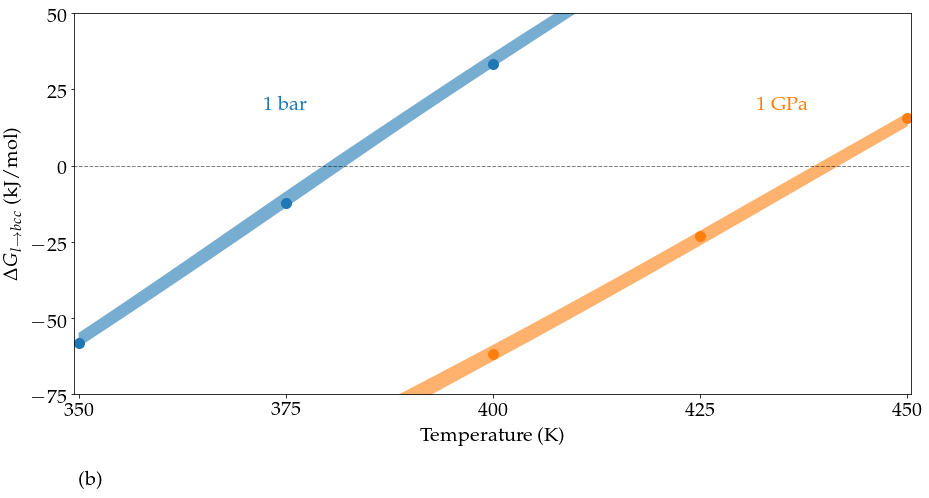

In [19]:
fig = plt.figure() 

x=np.linspace(340,460,5)
y=x*0.
plt.plot(x,y,'--',linewidth=1,color="black",alpha=0.5)

x=np.linspace(350,450,N)

plt.fill_between(x,freeEnergiesBccMean[:,0]-freeEnergiesBccErrors[:,0],freeEnergiesBccMean[:,0]+freeEnergiesBccErrors[:,0],alpha=0.6,color=palette[0],linewidth=0.)
plt.fill_between(x,freeEnergiesBccMean[:,M-1]-freeEnergiesBccErrors[:,M-1],freeEnergiesBccMean[:,M-1]+freeEnergiesBccErrors[:,M-1],alpha=0.6,color=palette[2],linewidth=0.)
plt.scatter(references0bar[:,0],-references0bar[:,1],s=100.,color=palette[0])
plt.scatter(references10000bar[:,0],-references10000bar[:,1],s=100,color=palette[2])

plt.xlim([349.5,450.5])
plt.ylim([-75,50])
plt.xticks(np.arange(350,475,25))
plt.yticks(np.arange(-75,75,25))

plt.xlabel("Temperature (K)")
plt.ylabel(r"$\Delta G_{l\rightarrow bcc}$ (kJ/mol)")

plt.text(375,20,"1 bar",color=palette[0],ha='center',va='center')
plt.text(435,20,"1 GPa",color=palette[2],ha='center',va='center')

plt.text(350,-105,r"(b)")

plt.show()

### Phase diagram

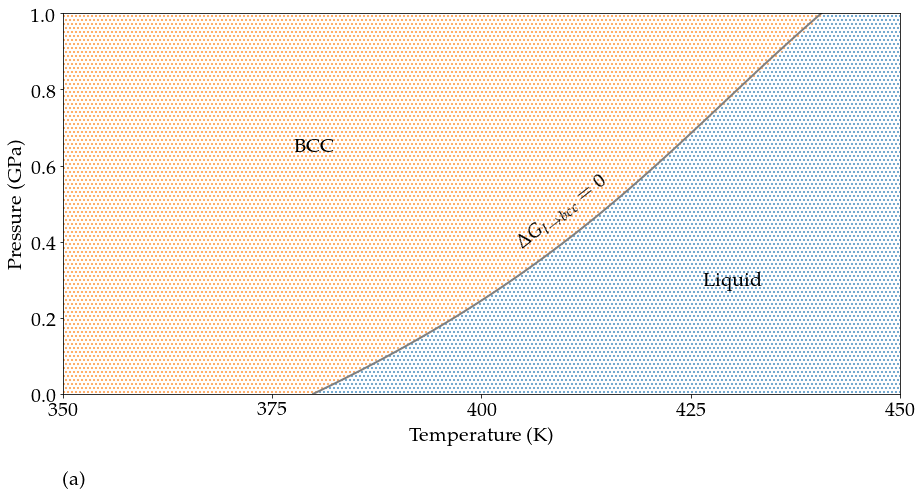

In [20]:
fig = plt.figure() 

N=41
M=41
x=np.linspace(350,450,N)
y=np.linspace(0,1,M)
X,Y=np.meshgrid(x,y,indexing='ij')


import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5
plt.fill([350,350,441,431,421,410,397,380],[0,1,1,0.8,0.6,0.4,0.2,0], fill=False, hatch='ooo',color=palette[2],alpha=0.6,linewidth=0.)
plt.fill([441,431,421,410,397,380,450,450],[1,0.8,0.6,0.4,0.2,0,0,1], fill=False, hatch='ooo',color=palette[0],alpha=0.6,linewidth=0.)


posmin=np.argmin(abs(freeEnergiesBccMean),axis=0)
from scipy.interpolate import interp1d, BSpline, splev, splrep
f = splrep(y,x[posmin],s=100)
y2=np.linspace(np.amin(y),np.amax(y),100)
plt.plot(splev(y2,f),y2,color='grey',linewidth=2.)

plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (GPa)")
plt.xticks(np.arange(350,475,25))

plt.text(380,0.65,"BCC",color="black",ha='center',va='center')
plt.text(430,0.3,"Liquid",color="black",ha='center',va='center')

plt.text(410,0.47,r"$\Delta G_{l\rightarrow bcc}=0$",color="black",rotation=38,va='center',ha='center')

plt.xlim([350,450])
plt.ylim([0,1])

plt.text(350,-0.24,r"(a)")

plt.show()

### Order parameter

In [21]:
def orderParameterMean(CV,bias,vol,temperature,pressure,tempPrimes,pressurePrimes):
    N=tempPrimes.shape[0]
    M=pressurePrimes.shape[0]
    OPM=np.zeros([N,M])
    beta=1./(0.00831441001626*temperature)
    for i in range(N):
        betaPrime=1./(0.00831441001626*tempPrimes[i])
        for j in range(M):
            mean=np.sum(CV*np.exp(beta*bias)*np.exp((beta-betaPrime)*energy+(beta*pressure-betaPrime*pressurePrimes[j])*vol))
            norm=np.sum(np.exp(beta*bias)*np.exp((beta-betaPrime)*energy+(beta*pressure-betaPrime*pressurePrimes[j])*vol))
            OPM[i,j]=mean/norm
    return OPM

In [22]:
N=161
M=161
tempPrimes=np.linspace(350,450,N)
pressurePrimes=0.06022140857*np.linspace(0,10000,M)
temperature=400
pressure=5000*0.06022140857
OPM=np.load("03_MultithermalMultibaric/orderParameterBcc.npy")
#OPM=orderParameterMean(CV,totalBias,vol,temperature,pressure,tempPrimes,pressurePrimes)

In [23]:
#np.save("orderParameterBcc.npy", OPM)

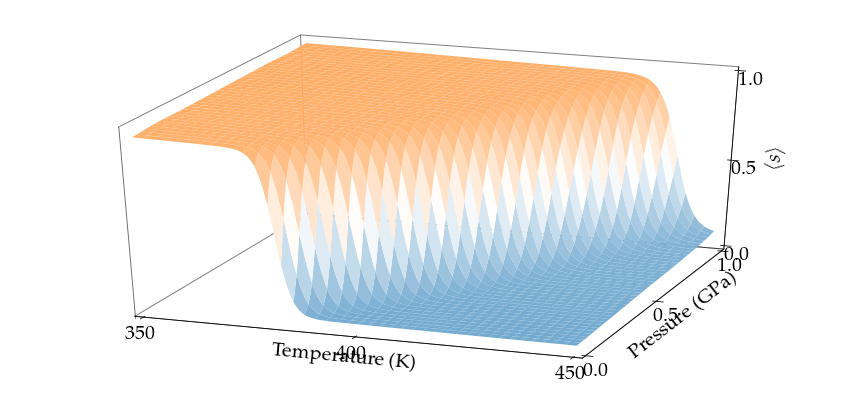

In [24]:
fig = plt.figure() 

from mpl_toolkits.mplot3d import Axes3D, art3d

ax3 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1, projection='3d')

N=161
M=161
x=np.linspace(350,450,N)
y=np.linspace(0,1,M)
X,Y=np.meshgrid(x,y,indexing='ij')

ax3.plot_surface(X,Y,OPM/250.,cmap=my_colormap,vmin=-0.25,vmax=1.25,alpha=1)
ax3.grid(False)
ax3.xaxis.pane.set_edgecolor('black')
ax3.yaxis.pane.set_edgecolor('black')
ax3.zaxis.pane.set_edgecolor('black')
ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False

ax3.set_zticks([0,0.5,1])
ax3.set_xticks([350,400,450])
ax3.set_yticks([0,0.5,1])

ax3.set_xlim([350,450])
ax3.set_ylim([0,1])
ax3.set_zlim([0,1])

ax3.set_xlabel("Temperature (K)",labelpad=-1)
ax3.set_ylabel("Pressure (GPa)",labelpad=-1)
ax3.set_zlabel(r"$\langle s \rangle$")

def lims(mplotlims):
    scale = 1.021
    offset = (mplotlims[1] - mplotlims[0])*scale
    return mplotlims[1] - offset, mplotlims[0] + offset

ax3.plot([348.5,348.5],[-0.03,-0.03],[-0.025,1.025],color="black",linewidth=0.9,alpha=0.6)
ax3.view_init(30, 290)

ax3.tick_params(pad=-1)

ax3.text(320,-0.1,-0.9,r"(c)")

plt.show()

Paper's figure

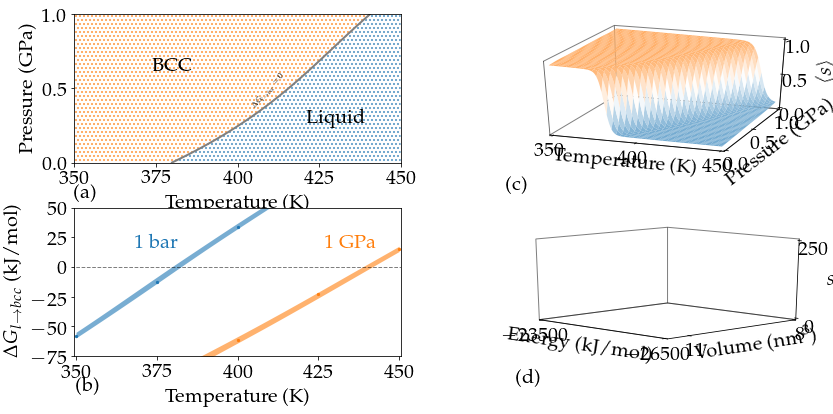

In [25]:
fig = plt.figure() 
from mpl_toolkits.mplot3d import Axes3D

ax1 = plt.subplot2grid((10,10), (0,0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((10,10), (5,0), colspan=4, rowspan=4)
ax3 = plt.subplot2grid((10,10), (0,5), colspan=4, rowspan=4, projection='3d')
ax4 = plt.subplot2grid((10,10), (5,5), colspan=4, rowspan=4, projection='3d')

#################
# Subplot 1
#################

N=41
M=41
x=np.linspace(350,450,N)
y=np.linspace(0,1,M)
X,Y=np.meshgrid(x,y,indexing='ij')


import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5
ax1.fill([350,350,441,431,421,410,397,380],[0,1,1,0.8,0.6,0.4,0.2,0], fill=False, hatch='ooo',color=palette[2],alpha=0.6,linewidth=0.)
ax1.fill([441,431,421,410,397,380,450,450],[1,0.8,0.6,0.4,0.2,0,0,1], fill=False, hatch='ooo',color=palette[0],alpha=0.6,linewidth=0.)


posmin=np.argmin(abs(freeEnergiesBccMean),axis=0)
from scipy.interpolate import interp1d, BSpline, splev, splrep
f = splrep(y,x[posmin],s=100)
y2=np.linspace(np.amin(y),np.amax(y),100)
ax1.plot(splev(y2,f),y2,color='grey',linewidth=2.)

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Pressure (GPa)")
ax1.set_xticks(np.arange(350,475,25))

ax1.text(380,0.65,"BCC",color="black",ha='center',va='center')
ax1.text(430,0.3,"Liquid",color="black",ha='center',va='center')

ax1.text(410,0.47,r"$\Delta G_{l\rightarrow bcc}=0$",color="black",rotation=48,va='center',ha='center',fontsize=8)

ax1.set_xlim([350,450])
ax1.set_ylim([0,1])

ax1.text(350,-0.24,r"(a)")

#################
# Subplot 2
#################

x=np.linspace(340,460,5)
y=x*0.
ax2.plot(x,y,'--',linewidth=1,color="black",alpha=0.5)

x=np.linspace(350,450,N)

ax2.fill_between(x,freeEnergiesBccMean[:,0]-freeEnergiesBccErrors[:,0],freeEnergiesBccMean[:,0]+freeEnergiesBccErrors[:,0],alpha=0.6,color=palette[0],linewidth=0.)
ax2.fill_between(x,freeEnergiesBccMean[:,M-1]-freeEnergiesBccErrors[:,M-1],freeEnergiesBccMean[:,M-1]+freeEnergiesBccErrors[:,M-1],alpha=0.6,color=palette[2],linewidth=0.)
ax2.scatter(references0bar[:,0],-references0bar[:,1],s=5.,color=palette[0])
ax2.scatter(references10000bar[:,0],-references10000bar[:,1],s=5,color=palette[2])

ax2.set_xlim([349.5,450.5])
ax2.set_ylim([-75,50])
ax2.set_xticks(np.arange(350,475,25))
ax2.set_yticks(np.arange(-75,75,25))

ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel(r"$\Delta G_{l\rightarrow bcc}$ (kJ/mol)")

ax2.text(375,20,"1 bar",color=palette[0],ha='center',va='center')
ax2.text(435,20,"1 GPa",color=palette[2],ha='center',va='center')

ax2.text(350,-105,r"(b)")

#################
# Subplot 3
#################

from mpl_toolkits.mplot3d import Axes3D, art3d

N=161
M=161
x=np.linspace(350,450,N)
y=np.linspace(0,1,M)
X,Y=np.meshgrid(x,y,indexing='ij')

ax3.plot_surface(X,Y,OPM/250.,cmap=my_colormap,vmin=-0.25,vmax=1.25,alpha=1)
ax3.grid(False)
ax3.xaxis.pane.set_edgecolor('black')
ax3.yaxis.pane.set_edgecolor('black')
ax3.zaxis.pane.set_edgecolor('black')
ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False

ax3.set_zticks([0,0.5,1])
ax3.set_xticks([350,400,450])
ax3.set_yticks([0,0.5,1])

ax3.set_xlim([350,450])
ax3.set_ylim([0,1])
ax3.set_zlim([0,1])

ax3.set_xlabel("Temperature (K)",labelpad=-1)
ax3.set_ylabel("Pressure (GPa)",labelpad=-1)
ax3.set_zlabel(r"$\langle s \rangle$")

def lims(mplotlims):
    scale = 1.021
    offset = (mplotlims[1] - mplotlims[0])*scale
    return mplotlims[1] - offset, mplotlims[0] + offset

ax3.plot([348.5,348.5],[-0.03,-0.03],[-0.025,1.025],color="black",linewidth=0.9,alpha=0.6)
ax3.view_init(30, 290)

ax3.tick_params(pad=-1)

ax3.text(320,-0.1,-0.9,r"(c)")

#################
# Subplot 4
#################

from matplotlib.cbook import get_sample_data

#im = plt.imread(get_sample_data('/home/piaggp/Desktop/mi_clepsidra_2.png'))
size=0.22
newax = fig.add_axes([0.59, 0.23, size, size], anchor='SW', zorder=10)
#newax.imshow(im, interpolation='nearest')
newax.axis('off')
           
ax4.view_init(15, 135)

ax4.set_xlim([-26500,-23500])
ax4.set_ylim([8,11.5])
ax4.set_zlim([0,250])

ax4.grid(False)
ax4.xaxis.pane.set_edgecolor('black')
ax4.yaxis.pane.set_edgecolor('black')
ax4.zaxis.pane.set_edgecolor('black')
ax4.xaxis.pane.fill = False
ax4.yaxis.pane.fill = False
ax4.zaxis.pane.fill = False

ax4.set_xlabel("Energy (kJ/mol)",labelpad=-1)
ax4.set_ylabel(r"Volume (nm$^3$)",labelpad=-1)
ax4.set_zlabel(r"$s$",labelpad=-5)

ax4.tick_params(pad=-1.5)
ax4.set_xticks([-26500,-23500])
ax4.set_yticks([8,11])
ax4.set_zticks([0,250])

ax4.text(-22500,11.35,-250.0,r"(d)")

#################
# Plot label
#################

#plt.savefig("/home/piaggp/Desktop/plot4-2.pdf", bbox_inches='tight',dpi=300)
#plt.savefig("plot4.png", bbox_inches='tight', dpi=300)

plt.show()